In [ ]:
from notebooks import *
sg.init(app=None)

/Users/danb/miniconda3/envs/bubo-features/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


The autoreload extension is already loaded. To reload it, use:

  %reload_ext

autoreload

The potoo.default_magic_magic extension is already loaded. To reload it, use:

  %reload_ext

potoo.default_magic_magic

2018-09-05 22:35.40

init

2018-09-05 22:35.42

init:done

In [ ]:
# For reference

def table_recs(
    recs,
    limit=None,
    more_cols=[],
    cols=xc_eda_cols,
    decorate=True,
    dist_bar_size=30,
    handtype_cmap=mpl_cmap_concat('tab10', 'tab20'),
    color_stack=False,
    **kwargs_recs_decorate,
):
    if decorate:
        recs = recs_decorate(recs, **kwargs_recs_decorate)
    return (recs
        .join(how='left', other=load_xc_handtype())
        .fillna({'handtype': ''})  # TODO TODO dev
        .pipe(df_col_map, handtype=lambda xs: [x[:3] for x in xs])
        .pipe(df_col_color_d, handtype=handtype_cmap, _stack=color_stack)
        [:limit]
        .pipe(lambda df: df if 'dist' not in df.columns else df_assign_first(df,
            dist_bar=lambda df: df.dist.map(lambda dist: text_bar(dist, max=df.dist.max(), norm=dist_bar_size, side='right')),
        ))
        .pipe(lambda df: df[[
            c
            for c in [
                'dist_bar', 'dist', 'handtype',
                'thumb', 'micro',
                *more_cols,
                *cols,
            ]
            if c in df.columns
        ]])
    )

def query_grid(
    search_recs,
    query_rec: QueryRec,
    pca_components,
    faster_dev=False,
    include_query_rec=True,
    show_id=False,
    limit=35,
    decorate=True,
    dist_bar_size=5,
    **kwargs,
) -> pd.DataFrame:
    query_rec = unpack_query_rec(query_rec, search_recs)
    if include_query_rec and query_rec.name not in search_recs.index:
        # Include query_rec in search_recs so it always shows up at top, for simple reference
        search_recs = pd.concat([
            DF([query_rec]).pipe(df_set_index_name, 'xc_id'),  # HACK Force compat with xc_recs, e.g. if from user_recs
            search_recs,
        ])
    if decorate:
        search_recs = sub_kwargs(recs_decorate, **kwargs)(search_recs)
    bys = [
        (lambda x: 'f', Search.X),
        (lambda x: 'p', sg.search.species_proba),
        *[(lambda x: x.components, proba_pca_slice(c)) for c in pca_components],
    ]
    if faster_dev:
        limit = 10
        bys = bys[:3]
    return DF(dict(flatten(
        [
            *([('%s/id'    % by_desc, df.xc_id)] if show_id else []),
            ('%s/dist'     % by_desc, df_map_rows(df, lambda row: df_cell_stack([row.dist_bar, row.dist]))),
            ('%s/h'        % by_desc, df.handtype),
            *([('%s/thumb' % by_desc, df.thumb)] if 'micro_s' not in kwargs or 'thumb_s' in kwargs else []),
            *([('%s/micro' % by_desc, df.micro)] if 'micro_s' in kwargs else []),
        ]
        for by_desc_f, by in bys
        for by_desc in [by_desc_f(by)]
        for df in [
            sub_kwargs(table_recs, **kwargs)(
                recs=rec_neighbors_by(search_recs=search_recs, query_rec=query_rec, by=by),
                limit=limit, dist_bar_size=dist_bar_size,
                color_stack=True,
                decorate=False,  # Already done above (once, instead of len(bys) times here)
            )
            .sort_values('dist')
            .reset_index()
        ]
    )))

@dataclass
class proba_pca_slice:
    components: Union[int, float]
    def __call__(self, df):
        proba_pca_var = df.proba_pca_var.iloc[0]
        return [
            row.proba_pca[:n]
            for row in df_rows(df)
            for n in [
                len(row.proba_pca_var) if self.components is None else
                self.components if isinstance(self.components, int) else
                (row.proba_pca_var <= self.components).sum()
            ]
        ]

def recs_decorate(
    recs,
    size='big',  # 'big' | 'small'
    thumb_s=2,
    micro_s=13,
):
    cols = dict()
    if size == 'big':
        cols.update(dict(
            thumb=df_cell_spectros(plot_thumb.many, sg.features, thumb_s=thumb_s, scale=dict(h=26)),
            micro=df_cell_spectros(plot_spectro_micro.many, sg.features, wrap_s=micro_s, scale=dict(h=26)),
        ))
    else:
        cols.update(dict(
            thumb=df_cell_spectros(plot_thumb.many, sg.features, thumb_s=thumb_s, scale=dict(h=13)),
            micro=df_cell_spectros(plot_spectro_micro.many, sg.features, wrap_s=micro_s*2, scale=dict(h=13)),  # HACK micro_s*2
        ))
    return df_assign_first(recs, **cols)

def user_query_rec(
    pca: recs_pca_norm,
    user_rec: Recording,
    show_rec=True,
    show_probs=10,
    show_spectro=False,  # Prefer grid_search(include_query_rec=True)
    **kwargs,
) -> Recording:
    if show_rec: print(rec_str_line(user_rec))
    if show_probs: display(rec_probs(user_rec, sg.search)[:show_probs])
    if show_spectro: display(plot_spectro_micro(user_rec, sg.features, **kwargs, show=False))
    return pca.transform_rec(user_rec)

[skip]

In [ ]:
# TODO def xc_similar_html(xc_id: int) -> pd.DataFrame:
xc_id = 414174
quality = ['A', 'B']
n_sp = 5
n_recs_r = 50
n_total = 25
thumb_s = 1.5
audio_s = 10
scale = 2

In [ ]:
query_rec = (sg.xc_meta
    [lambda df: df.id == xc_id]
    .pipe(recs_featurize, spectro=False, thumb_s=None, audio_s=None, scale=1)
    .pipe(lambda df: one(df_rows(df)))
)

[05:35:42.746] INFO   [2/3 slower] Loading xc.metadata -> xc_raw_recs (.audio, more metadata)...

[05:35:42.772] INFO   [3/3 slowest] Featurizing xc_raw_recs -> xc_recs (.audio, .feat, .spectro)...

[05:35:42.776] DEBUG  Load.audio:in

  len(recs): 1

  len(recs) per dataset: {xc: 1}

audio: [

] |   0% Completed |  0.0s

audio: [

#####################################################################################

] | 100% Completed |  0.1s

[05:35:42.907] DEBUG  Load.audio:out

  len(audio): 1

In [ ]:
query_probs = (
    rec_probs(query_rec, sg.search)
    [:n_sp]
)
query_probs

species      p
0    GTTO  0.062
1    HOWR  0.058
2    HOSP  0.053
3    COYE  0.045
4    RWBL  0.043

In [ ]:
# memory.log.level = 'debug'  # TODO Nontrivial number of cache misses slowing us down -- why are there misses?
search_recs = (sg.xc_meta
    # Filter
    [lambda df: df.species.isin(query_probs.species)]
    [lambda df: df.quality.isin(quality)]
    .pipe(df_remove_unused_categories)
    # Sample n_recs_r per species
    .groupby('species').apply(lambda g: (g
        .sample(n=n_recs_r)  # TODO HACK Sample to make go faster, until we build up a full cache
    ))
    .reset_index(level=0, drop=True)  # species, from groupby
    # Featurize
    .pipe(recs_featurize, spectro=False, thumb_s=None, audio_s=None, scale=1)
    # Include query_rec in results (already featurized)
    .pipe(lambda df: df if query_rec.name in df.index else pd.concat([
        DF([query_rec]).pipe(df_set_index_name, 'xc_id'),  # Restore index name, lost by df->series->df
        df,
    ]))
)
display(
    search_recs.species.value_counts(),
    search_recs[:10],
)

[05:35:43.245] INFO   [2/3 slower] Loading xc.metadata -> xc_raw_recs (.audio, more metadata)...

[05:35:43.279] DEBUG  Load.metadata:in

  len(recs): 250

  len(recs) per dataset: {xc: 250}

metadata: [

] |   0% Completed |  0.0s

metadata: [

##############################                                                    

] |  37% Completed |  0.1s

metadata: [

###########################################################################       

] |  91% Completed |  0.2s

metadata: [

##################################################################################

] | 100% Completed |  0.3s

[05:35:43.647] DEBUG  Load.metadata:out

  sum(duration_h): 4.29

  sum(samples_mb): 650.0

  sum(samples_n): 340859688

  n_species: 5

[05:35:45.151] INFO   [3/3 slowest] Featurizing xc_raw_recs -> xc_recs (.audio, .feat, .spectro)...

[05:35:45.156] DEBUG  Load.audio:in

  len(recs): 250

  len(recs) per dataset: {xc: 250}

audio: [

] |   0% Completed |  0.0s

audio: [

] |   0% Completed |  0.1s

audio: [

##################################                                                   

] |  40% Completed |  0.3s

audio: [

#################################################################################    

] |  96% Completed |  0.5s

audio: [

#####################################################################################

] | 100% Completed |  0.6s

[05:35:45.771] DEBUG  Load.audio:out

  len(audio): 250

feat: [

] |   0% Completed |  0.0s

feat: [

] |   0% Completed |  0.1s

feat: [

##############                                                                        

] |  16% Completed |  0.2s

feat: [

#######################                                                               

] |  27% Completed |  0.3s

feat: [

###########################################                                           

] |  50% Completed |  0.4s

feat: [

##################################################                                    

] |  58% Completed |  0.5s

feat: [

######################################################                                

] |  63% Completed |  0.6s

feat: [

##################################################################                    

] |  77% Completed |  0.7s

feat: [

############################################################################          

] |  88% Completed |  0.8s

feat: [

##############################################################################        

] |  91% Completed |  0.9s

feat: [

##############################################################################        

] |  91% Completed |  1.1s

feat: [

##############################################################################        

] |  91% Completed |  1.2s

feat: [

##############################################################################        

] |  91% Completed |  1.3s

feat: [

##############################################################################        

] |  91% Completed |  1.4s

feat: [

##############################################################################        

] |  91% Completed |  1.5s

feat: [

#################################################################################     

] |  94% Completed |  1.6s

feat: [

#################################################################################     

] |  94% Completed |  1.7s

feat: [

#################################################################################     

] |  94% Completed |  1.8s

feat: [

######################################################################################

] | 100% Completed |  1.9s

HOWR    51
COYE    50
RWBL    50
GTTO    50
HOSP    50
Name: species, dtype: int64

dataset species species_com_name species_query  duration_s  samples_mb  samples_n basename   species_longhand                         id                           path  downloaded subspecies                                                            recordist        country                                             locality     lat      lng          type quality       date    time license_type license_detail                                       license                                url                              download                                                                                                                                                                                                  remarks bird_seen playback_used elevation                                                                                                                                                                                               background         volume          speed          pitch         length number_of_notes       variable    channels sampling_rate bitrate_of_mp3       state_only                                place_only                     state                                                               place  year  month month_day  hour                                background_species  n_background_species                                                     place_only_stack                          state_only_stack                                                                                        place_stack                                          state_stack                                                               background_species_stack                                                                                                                                                                                            remarks_stack                                                                                         audio                                                                                                                                                                                                     feat  spectro
xc_id                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         

In [ ]:
result_recs = (
    rec_neighbors_by(
        query_rec=query_rec,
        search_recs=search_recs if query_rec.name in search_recs.index else pd.concat([
            DF([query_rec]).pipe(df_set_index_name, 'xc_id'),  # HACK Force compat with xc_recs, e.g. if from user_recs
            search_recs,
        ]),
        by=Search.X,  # TODO Add user control to toggle dist function
    )
    # .groupby('species').apply(lambda g: (g
    #     .sort_values('dist', ascending=True)
    #     [:n_recs]  # TODO Restore n_recs later, maybe after we've built enough cache to no longer need n_recs_r
    # ))
    # .reset_index(level=0, drop=True)  # species, from groupby
    .sort_values('dist', ascending=True)
    [:n_total]
    .drop(columns=['feat'])
)
display(
    result_recs.species.value_counts(),
    result_recs[['dist', 'species']][:10],
)

HOWR    11
HOSP     5
GTTO     5
COYE     4
Name: species, dtype: int64

dist species
xc_id                 
414174   0.000    HOWR
247381  40.491    HOWR
213742  43.547    HOWR
381852  44.579    HOSP
347633  45.193    HOWR
112047  46.590    GTTO
333067  47.372    HOWR
188395  47.883    COYE
158999  48.017    COYE
131168  48.344    HOWR

[05:37:13.655] INFO   [3/3 slowest] Featurizing xc_raw_recs -> xc_recs (.audio, .feat, .spectro)...

[05:37:13.678] DEBUG  Features.spectros:in

  len(recs): 25

  len(recs) per dataset: {xc: 25}

  sum(duration_h): 0.367

  sum(samples_mb): 55.5

  sum(samples_n): 29116100

spectro: [

] |   0% Completed |  0.0s

spectro: [

###################################################################################

] | 100% Completed |  0.1s

[05:37:13.805] DEBUG  Features.spectros:out

  (f, sum(t)): [40, 113702]

plot_thumb.many: [

] |   0% Completed |  0.0s

plot_thumb.many: [

#########################                                                  

] |  34% Completed |  0.1s

plot_thumb.many: [

###########################################################################

] | 100% Completed |  0.3s

plot_spectro_micro.many: [

] |   0% Completed |  0.0s

plot_spectro_micro.many: [

] |   0% Completed |  0.1s

plot_spectro_micro.many: [

#####################                                              

] |  32% Completed |  0.3s

plot_spectro_micro.many: [

#############################                                      

] |  44% Completed |  0.4s

plot_spectro_micro.many: [

############################################                       

] |  66% Completed |  0.5s

plot_spectro_micro.many: [

################################################################   

] |  96% Completed |  0.6s

plot_spectro_micro.many: [

###################################################################

] | 100% Completed |  0.7s

xc_id    dist species     species_com_name quality                                                      thumb                                                      micro month_day                               background_species                                                                            place                                                                                                                                                                                                  remarks
0   <a href="https://www.xeno-canto.org/414174">XC414174</a>   0.000    HOWR           House Wren       A  df_cell_display(value=<IPython.core.display.HTML object>)  df_cell_display(value=<IPython.core.display.HTML object>)     01-29                                                                        Santa Rita do Novo Destino, Goiás, Chácara Jayrson, Brazil                                                                                                                                                                                                         
1   <a href="https://www.xeno-canto.org/247381">XC247381</a>  40.491    HOWR           House Wren       B  df_cell_display(value=<IPython.core.display.HTML object>)  df_cell_display(value=<IPython.core.display.HTML object>)     05-28                                                                                  Belo Oriente, Belo Oriente, Minas Gerais, Brazil                                                                                                                                                                                                         
2   <a href="https://www.xeno-canto.org/213742">XC213742</a>  43.547    HOWR           House Wren       A  df_cell_display(value=<IPython.core.display.HTML object>)  df_cell_display(value=<IPython.core.display.HTML object>)     12-14                                  Hummingbird sp.                                          Hostal Izhcayluma, Vilcambamba, Ecuador                                                                                                                            The bird was singing early in the morning.  A hummingbird was buzzing nearby.
3   <a href="https://www.xeno-canto.org/381852">XC381852</a>  44.579    HOSP        House Sparrow       B  df_cell_display(value=<IPython.core.display.HTML object>)  df_cell_display(value=<IPython.core.display.HTML object>)     07-29                                                                                                  Vauvert, Gard, Occitanie, France                                                                                                                                                                                                         
4   <a href="https://www.xeno-canto.org/347633">XC347633</a>  45.193    HOWR           House Wren       A  df_cell_display(value=<IPython.core.display.HTML object>)  df_cell_display(value=<IPython.core.display.HTML object>)     11-05                                                                                      , Archipiélago de Jambelí (Casitas), Ecuador                                                                                                                                                                                                         
5   <a href="https://www.xeno-canto.org/112047">XC112047</a>  46.590    GTTO  Green-tailed Towhee       B  df_cell_display(value=<IPython.core.display.HTML object>)  df_cell_display(value=<IPython.core.display.HTML object>)     05-04  HOFI, American Yellow Warbler, GIWO, BCFL, BEWR  San Bernardino National Wildlife Refuge, Cochise County, Arizona, United States                                                                                                                                                                             wintering bird (or migrant);
6   <a href="https://www.xeno-canto.org/333067">XC333067</a>  47.372    HOWR           House Wren   
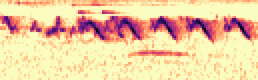
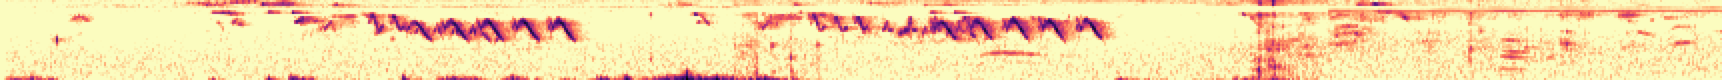
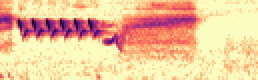
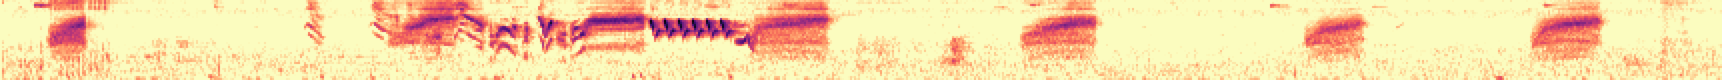
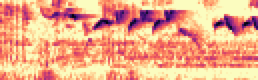
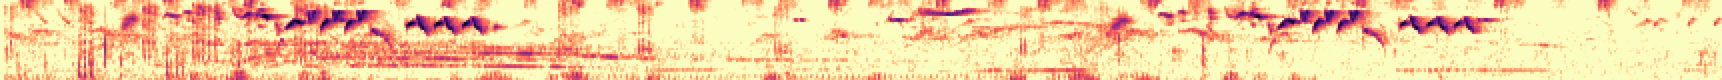
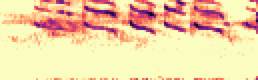
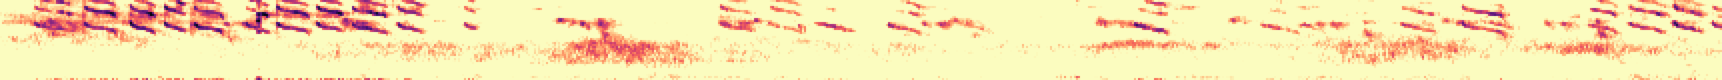
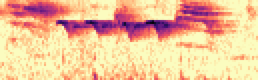
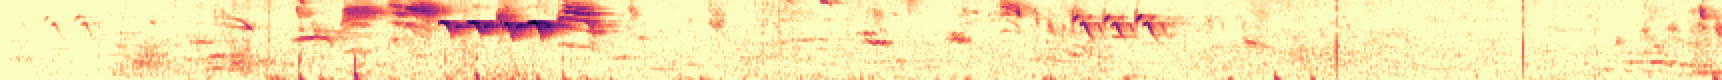
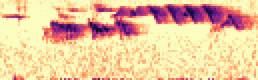
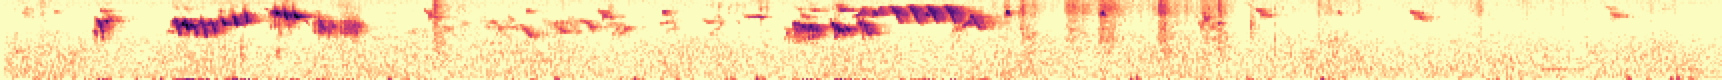
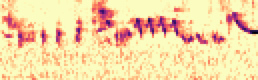
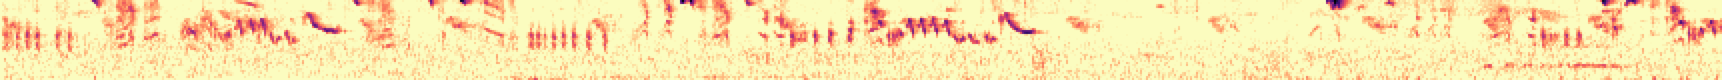
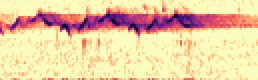
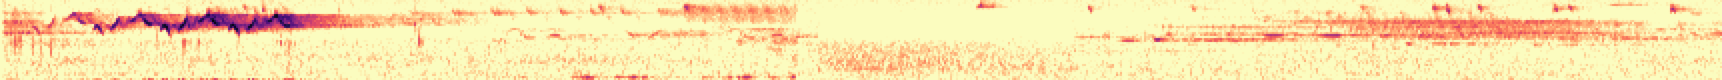
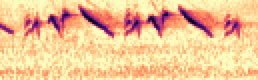
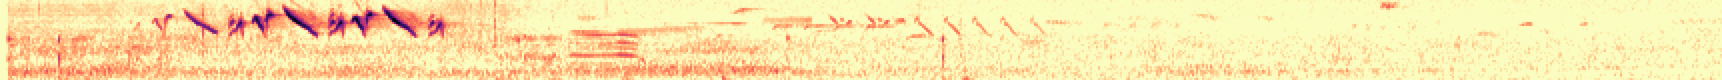
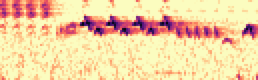
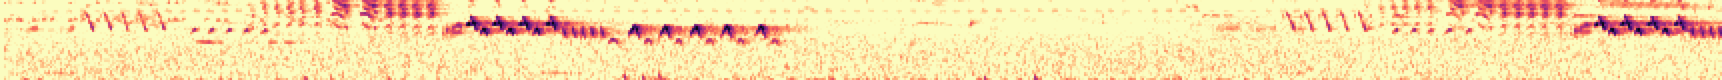
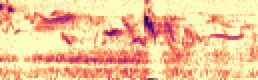
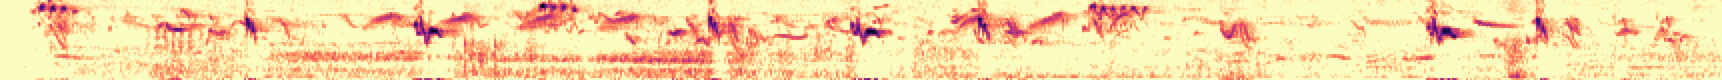
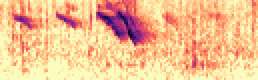
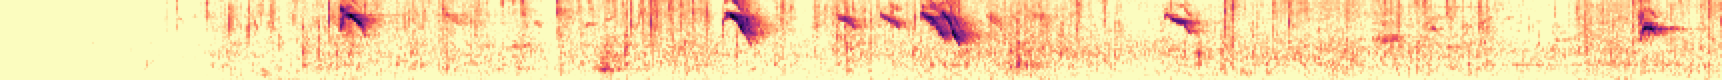
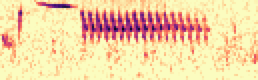
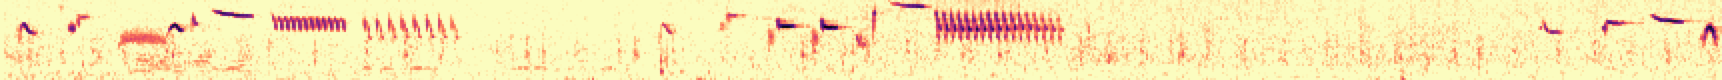
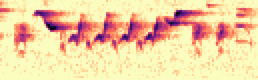
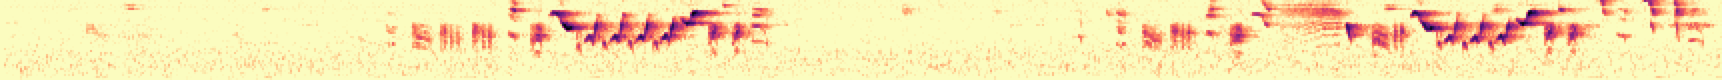
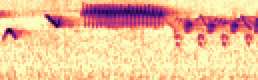
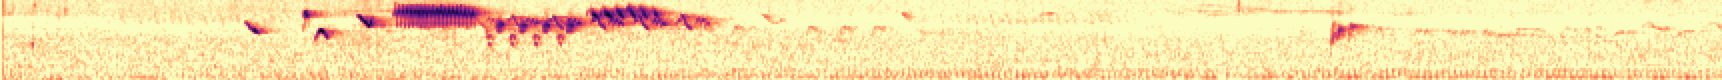
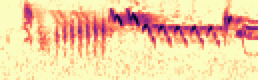
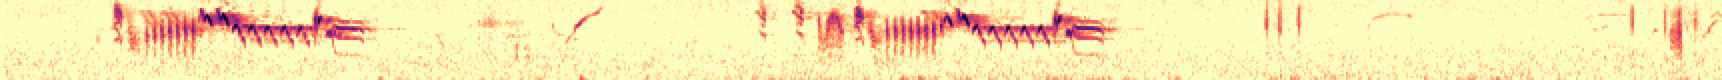
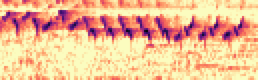
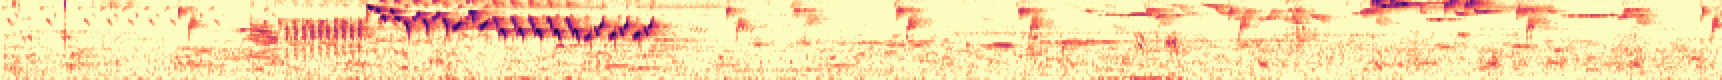
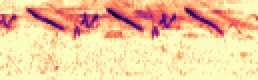
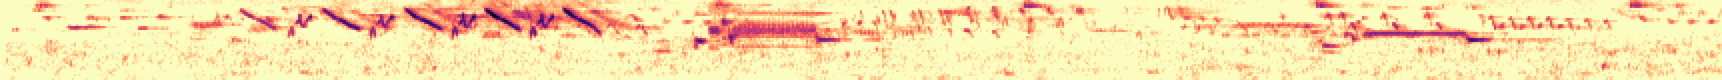
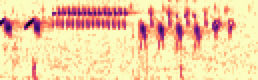
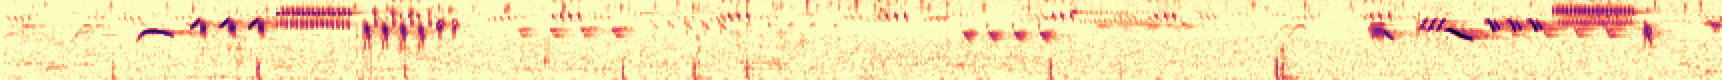
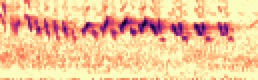
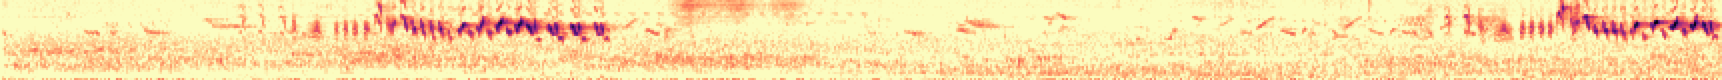
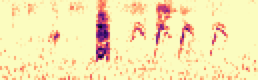
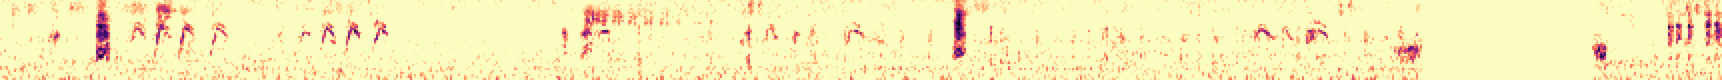
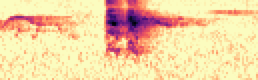
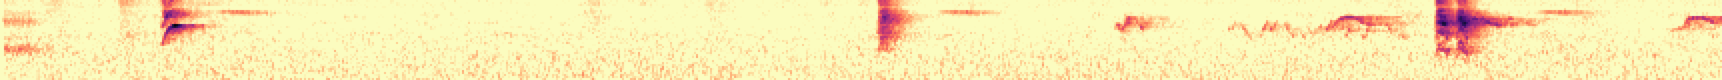
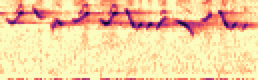
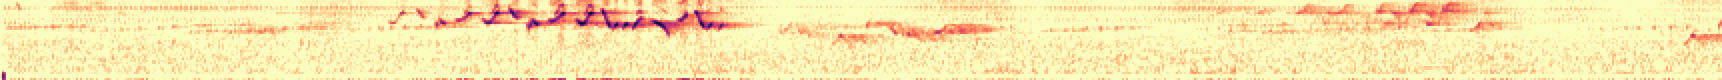
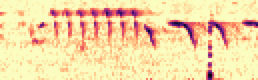
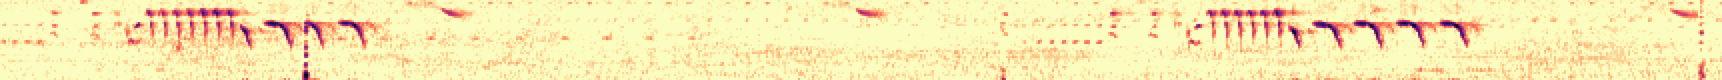
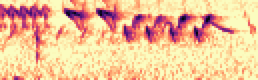
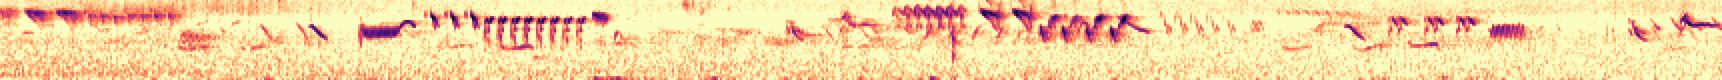

In [ ]:
(result_recs
    .reset_index()
    .pipe(recs_featurize, thumb_s=thumb_s, audio_s=audio_s, scale=scale)
    .pipe(recs_view)
    [lambda df: [
        'xc_id', 'dist', 'species', 'species_com_name', 'quality',
        *[c for c in ['thumb', 'micro'] if c in df],
        'month_day', 'background_species', 'place', 'remarks',
    ]]
    .pipe(df_col_map,
        background_species=lambda xs: ', '.join(xs),
    )
)

In [ ]:
xc_similar_html(
    ...
)